In [1]:
#import libraries
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    import math
    import pandas as pd  # Dataframes
    import numpy as np   # Numerical analysis
    import seaborn as sns # Plotting
    import matplotlib.pyplot as plt # More plotting
    from sklearn import cross_validation, linear_model, grid_search, metrics
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier
    import statsmodels.formula.api as smf
    import statsmodels.iolib.summary
    from statsmodels.stats.descriptivestats import Describe
    
    %matplotlib inline

/Users/mattbritton/anaconda/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


In [2]:
#function used by all ACS datasets below to get a 5-digit zip as the index
def clean_and_index_zip(df, colZip="Zip", bolSetIndex=True):

    df[colZip] = df[colZip].astype(str)
    df[colZip] = df[colZip].map(lambda x: x.rjust(5,"0"))
    if bolSetIndex == True:
        df.set_index(colZip, inplace=True)

In [3]:
#function used by all ACS datasets below to trim them down to just the NYC ZCTAs
def shrink_to_NYC_zips(dfData, dfZip):
    
    dfDataShrink = dfData.join(dfZip, how="inner", sort=True)
    dfDataShrink.drop(dfZip.columns,axis=1,inplace=True)
    return dfDataShrink

In [4]:
# import data and check head
# 311 data
dfRaw311 = pd.read_csv("Data/311 2014 Incidents.csv")
dfRaw311.head(1)

/Users/mattbritton/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unique Key,Created Date,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Status,Resolution Description,Resolution Action Updated Date,Borough,School or Citywide Complaint
0,28457271,07/11/2014 03:08:58 PM,Department of Transportation,Sidewalk Condition,Defacement,Sidewalk,11368,Closed,The Department of Transportation inspected the...,08/05/2014 12:41:37 PM,QUEENS,NaN


In [5]:
#import Zip Code to ZCTA mapping
#prepare as dictionary for use in shrinking 311 dataset, and as dataframe for use in shrink_to_NYC_Zips function
dfZCTA = pd.read_csv("Data/2014 US Zip Code to ZCTA.csv", usecols=["ZIP", "ZCTA"])
dfZCTA["ZIP"] = dfZCTA["ZIP"].astype(str)
dfZCTA["ZIP"] = dfZCTA["ZIP"].map(lambda x: x.rjust(5,"0"))
dfZCTA["ZCTA"] = dfZCTA["ZCTA"].astype(str)
dfZCTA["ZCTA"] = dfZCTA["ZCTA"].map(lambda x: x.rjust(5,"0"))
dfZCTA.set_index("ZIP", inplace=True)
dctZiptoZCTA = dfZCTA.to_dict()

In [6]:
#311 data has different issues with the zip format (no dropped zeroes, but it has Zip+4)
#so clean without the clean_and_index_zip function
#also replace zip code with Zip Code Tabulation Area, the rolled-up id used by the ACS
dfRaw311["Zip"] = dfRaw311["Incident Zip"].astype(str)
dfRaw311["Zip"] = dfRaw311["Zip"].map(lambda x: x[0:5])
dfRaw311["Zip"] = dfRaw311["Zip"].map(lambda x: (dctZiptoZCTA["ZCTA"][x] if (x in dctZiptoZCTA["ZCTA"]) else np.nan))

In [7]:
#drop the small percentage of calls with improperly coded zip codes
print("311 data has %d rows" %(len(dfRaw311)))
dfRaw311.dropna(how="any",axis=0,subset=["Zip"], inplace=True)
print("311 data has %d rows after null zips removed" %(len(dfRaw311)))

311 data has 1952142 rows
311 data has 1951589 rows after null zips removed


In [8]:
#set zip as index here to make joins easier later
#data transformation happens later, so note that the index is not unique yet at this stage
dfRaw311.set_index("Zip", inplace=True)
dfRaw311.index.value_counts() [:10]

11226    37875
10467    32620
10458    28272
11207    26224
10453    25132
10468    25032
11221    24209
11211    24160
10031    23954
10457    23374
Name: Zip, dtype: int64

In [9]:
#import NYC Zip Code list and transform to ZCTA
dfZip = pd.read_csv("Data/NYC Zip Codes.csv", usecols=["Postal Code"])
dfZip["Zip"] = dfZip["Postal Code"].astype(str)
dfZip["Zip"] = dfZip["Zip"].map(lambda x: x[0:5])
dfZip["Zip"] = dfZip["Zip"].map(lambda x: (dctZiptoZCTA["ZCTA"][x] if (x in dctZiptoZCTA["ZCTA"]) else np.nan))

dfZip.dropna(how="any",axis=0,subset=["Zip"], inplace=True)
dfZip = pd.DataFrame(dfZip["Zip"].unique())
dfZip.columns = ["Zip"]
dfZip.set_index("Zip", inplace=True)

In [10]:
#some calls come from the tri-state area, so join to remove non-NYC zips from 311 data
print("311 data has %d rows" %(len(dfRaw311)))
dfRaw311NYC = shrink_to_NYC_zips(dfRaw311, dfZip)
print("311 data has %d rows after non-NYC Zip codes removed" %(len(dfRaw311NYC)))

311 data has 1951589 rows
311 data has 1945613 rows after non-NYC Zip codes removed


In [11]:
# import data and check head
# Population
# Also slice this to remove anything except zip and total population
dfPop = pd.read_csv("Data/ACS 2014 National Population Estimates by Zip.csv", dtype = {1:str}, header=1, usecols=[1,3],\
                      names=["Zip", "Population"])

#cast columns and make index for ease of joining
clean_and_index_zip(dfPop, "Zip")
dfPop['Population'] = dfPop['Population'].astype(np.int)
dfPopNYC = shrink_to_NYC_zips(dfPop, dfZip)

print('Population data has %s rows' %(len(dfPopNYC)))
print("This will be shrunk to %s rows after it's joined to other data sets" %(len(dfPopNYC[dfPopNYC["Population"] > 500])) + \
      ", and small zip codes (WTC, outlying islands,etc) are dropped" )

Population data has 210 rows
This will be shrunk to 178 rows after it's joined to other data sets, and small zip codes (WTC, outlying islands,etc) are dropped


In [12]:
# import data and check head
# Economic Characteristics by Zip
# slice out relevant columns
lstEconCols = ["Id2", \
               "Percent; EMPLOYMENT STATUS - Population 16 years and over - In labor force - Civilian labor force - Unemployed",\
              "Percent; COMMUTING TO WORK - Workers 16 years and over - Walked",\
              "Percent; COMMUTING TO WORK - Workers 16 years and over - Worked at home",\
              "Estimate; COMMUTING TO WORK - Mean travel time to work (minutes)",\
              "Estimate; INCOME AND BENEFITS (IN 2014 INFLATION-ADJUSTED DOLLARS) - Total households - Median household income (dollars)",\
              ]

dfEcon = pd.read_csv("Data/ACS 2014 NY State Economic Characteristics by Zip.csv", header=1, usecols=lstEconCols)

#set column names
dfEcon.columns = ["Zip", "Unemployment Rate", "Percent Walking to Work", "Percent Worked at Home","Mean Travel Time to Work"\
                  , "Median Household Income"]

#pad zip with zeroes (poor formatting in original file) and set as index for ease of joining
clean_and_index_zip(dfEcon, "Zip")

#drop null values
dfEcon.replace("-", np.nan, inplace=True)
print("econ data length before cleaning nulls: %s" %(len(dfEcon)))
dfEcon.dropna(how="any", inplace=True)
print("econ data length after cleaning nulls: %s" %(len(dfEcon)))

#convert remaining fields to numeric
dfEcon["Median Household Income"] = dfEcon["Median Household Income"].replace("250,000+", "250000")
dfEcon["Mean Travel Time to Work"] = dfEcon["Mean Travel Time to Work"].replace("N", "-1")
for col in dfEcon.columns:
    if col != "Zip":
        dfEcon[col] = dfEcon[col].astype(np.float)
        
#make combined column "Worked near home" as proxy for presence in the neighborhood
#columns need to be cast first
dfEcon["Percent Worked near home"] = dfEcon["Percent Walking to Work"] + dfEcon["Percent Worked at Home"]
dfEcon.drop(["Percent Walking to Work", "Percent Worked at Home"],axis=1,inplace=True)        

dfEconNYC= shrink_to_NYC_zips(dfEcon, dfZip)

#display
print('Economic data has %s rows' %(len(dfEconNYC)))
dfEconNYC.head(5)

econ data length before cleaning nulls: 1794
econ data length after cleaning nulls: 1707
Economic data has 178 rows


,Unemployment Rate,Mean Travel Time to Work,Median Household Income,Percent Worked near home
Zip,,,,
10001,6.2,24.9,81445.0,46.3
10002,6.2,31.3,32966.0,30.3
10003,4.6,25.2,97524.0,32.3
10004,8.0,24.2,123409.0,36.4
10005,2.8,25.7,121840.0,27.1


In [13]:
# import data and check head
# Median rent by Zip
# slice out relevant columns
lstRentCols = ["Id2", "Estimate; Median gross rent"]

dfRent = pd.read_csv("Data/ACS 2014 NY State Median Rent.csv", header=1, usecols=lstRentCols)

#set column names
dfRent.columns = ["Zip", "Median Rent"]

#pad zip with zeroes (poor formatting in original file) and set as index for ease of joining
clean_and_index_zip(dfRent, "Zip")

#drop null values
dfRent.replace("-", np.nan, inplace=True)
print("rent data length before cleaning nulls: %s" %(len(dfRent)))
dfRent.dropna(how="any", inplace=True)
print("rent data length after cleaning nulls: %s" %(len(dfRent)))

#convert remaining fields to numeric
dfRent["Median Rent"] = dfRent["Median Rent"].replace("2,000+", "2000")
for col in dfRent.columns:
    if col != "Zip":
        dfRent[col] = dfRent[col].astype(np.float)


dfRentNYC= shrink_to_NYC_zips(dfRent, dfZip)

#display
print('Rent data has %s rows' %(len(dfRentNYC)))
dfRentNYC.head(5)

rent data length before cleaning nulls: 1794
rent data length after cleaning nulls: 1484
Rent data has 178 rows


,Median Rent
Zip,
10001,1865.0
10002,863.0
10003,1955.0
10004,2000.0
10005,2000.0


In [14]:
# import data and check head
# Median year home built by Zip
# slice out relevant columns
lstYearCols = ["Id2", "Estimate; Median year structure built"]

dfYearBuilt = pd.read_csv("Data/ACS 2014 NY State Median Year Structure built by Zip.csv", header=1, usecols=lstYearCols)

#set column names
dfYearBuilt.columns = ["Zip", "Median Year Built"]

#pad zip with zeroes (poor formatting in original file) and set as index for ease of joining
clean_and_index_zip(dfYearBuilt, "Zip")

#drop null values
dfYearBuilt.replace("-", np.nan, inplace=True)
print("year built data length before cleaning nulls: %s" %(len(dfYearBuilt)))
dfYearBuilt.dropna(how="any", inplace=True)
print("year built data length after cleaning nulls: %s" %(len(dfYearBuilt)))

#convert remaining fields to numeric
dfYearBuilt["Median Year Built"] = dfYearBuilt["Median Year Built"].replace("1939-", "1939")
for col in dfYearBuilt.columns:
    if col != "Zip":
        dfYearBuilt[col] = dfYearBuilt[col].astype(np.int)     

dfYearBuilt["Median age of housing"] = 2015 - (dfYearBuilt["Median Year Built"])       
dfYearBuilt.drop(["Median Year Built"], axis=1,inplace=True)    
    

dfYearBuiltNYC = shrink_to_NYC_zips(dfYearBuilt, dfZip)

#display
print('Housing year data has %s rows' %(len(dfYearBuiltNYC)))
dfYearBuiltNYC.head(5)

year built data length before cleaning nulls: 1794
year built data length after cleaning nulls: 1721
Housing year data has 178 rows


,Median age of housing
Zip,
10001,53
10002,64
10003,76
10004,76
10005,64


In [15]:
# import data and check head
# Commuting during rush hour by Zip
# slice out relevant columns
lstCommuteCols = ["Id2", \
                  "Total; Estimate; Workers 16 years and over who did not work at home - TIME LEAVING HOME TO GO TO WORK - 12:00 a.m. to 4:59 a.m.",\
                 "Total; Estimate; Workers 16 years and over who did not work at home - TIME LEAVING HOME TO GO TO WORK - 9:00 a.m. to 11:59 p.m."]

dfCommuteHours = pd.read_csv("Data/ACS 2014 NY State Commuting Characteristics.csv", header=1, usecols=lstCommuteCols)

#set column names
dfCommuteHours.columns = ["Zip", "Percent commuting late night", "Percent commuting during the day"]

#pad zip with zeroes (poor formatting in original file) and set as index for ease of joining
clean_and_index_zip(dfCommuteHours, "Zip")

#drop null values
dfCommuteHours.replace("-", np.nan, inplace=True)
print("commuting hour data length before cleaning nulls: %s" %(len(dfCommuteHours)))
dfCommuteHours.dropna(how="any", inplace=True)
print("commuting hour data length after cleaning nulls: %s" %(len(dfCommuteHours)))

for col in dfCommuteHours.columns:
    if col != "Zip":
        dfCommuteHours[col] = dfCommuteHours[col].astype(np.float)
        
#convert remaining fields to numeric
dfCommuteHours["Percent commuting during business hours"] = 100 - (dfCommuteHours["Percent commuting late night"]\
                                                                   + dfCommuteHours["Percent commuting during the day"])        
dfCommuteHours.drop(["Percent commuting late night", "Percent commuting during the day"], axis=1,inplace=True)               

dfCommuteHoursNYC = shrink_to_NYC_zips(dfCommuteHours, dfZip)

#display
print('Commute data has %s rows' %(len(dfCommuteHoursNYC)))
dfCommuteHoursNYC.head(5)

commuting hour data length before cleaning nulls: 1794
commuting hour data length after cleaning nulls: 1744
Commute data has 180 rows


,Percent commuting during business hours
Zip,
10001,64.6
10002,57.2
10003,62.4
10004,74.8
10005,75.3


In [16]:
# import data and check head
# Housing type by Zip
# slice out relevant columns
lstHousingCols = ["Id2", \
                  "Total; Estimate; HOUSING TENURE - Renter-occupied housing units"]

dfHousing = pd.read_csv("Data/ACS 2014 NY State Housing and Household Types.csv", header=1, usecols=lstHousingCols)

#set column names
dfHousing.columns = ["Zip", "Percent of units rented"]

#pad zip with zeroes (poor formatting in original file) and set as index for ease of joining
clean_and_index_zip(dfHousing, "Zip")

#drop null values
dfHousing.replace("-", np.nan, inplace=True)
print("housing data length before cleaning nulls: %s" %(len(dfHousing)))
dfHousing.dropna(how="any", inplace=True)
print("housing data length after cleaning nulls: %s" %(len(dfHousing)))

for col in dfHousing.columns:
    if col != "Zip":
        dfHousing[col] = dfHousing[col].astype(np.float)              

dfHousingNYC = shrink_to_NYC_zips(dfHousing, dfZip)

#display
print('Housing data has %s rows' %(len(dfHousingNYC)))
dfHousingNYC.head(5)

housing data length before cleaning nulls: 1794
housing data length after cleaning nulls: 1742
Housing data has 178 rows


,Percent of units rented
Zip,
10001,72.6
10002,86.6
10003,69.0
10004,70.8
10005,86.7


In [17]:
# import data and check head
# Age breakdown by Zip
# slice out relevant columns
lstAgeCols = ["Id2",\
                 "Total; Estimate; AGE - Under 5 years","Total; Estimate; AGE - 5 to 9 years",\
                 "Total; Estimate; AGE - 10 to 14 years", "Total; Estimate; AGE - 65 to 69 years",\
                 "Total; Estimate; AGE - 70 to 74 years", "Total; Estimate; AGE - 75 to 79 years",\
                 "Total; Estimate; AGE - 80 to 84 years", "Total; Estimate; AGE - 85 years and over",\
                 "Total; Estimate; SUMMARY INDICATORS - Median age (years)"]

dfAge = pd.read_csv("Data/ACS 2014 NY State Age Breakdowns by Zip.csv", header=1, usecols=lstAgeCols)

#set column names
dfAge.columns = ["Zip", "Under 5", "5-9", "10-14", "65-69", "70-74", "75-79", "80-84", "85+", "Median Age"]

#pad zip with zeroes (poor formatting in original file) and set as index for ease of joining
clean_and_index_zip(dfAge, "Zip")

#drop null values
dfAge.replace("-", np.nan, inplace=True)
print("age data length before cleaning nulls: %s" %(len(dfAge)))
dfAge.dropna(how="any", inplace=True)
print("age data length after cleaning nulls: %s" %(len(dfAge)))

for col in dfAge.columns:
    if col != "Zip":
        dfAge[col] = dfAge[col].astype(np.float)
        
#convert remaining fields to numeric
dfAge["Under 14"] = dfAge["Under 5"] + dfAge["5-9"] + dfAge["10-14"]
dfAge["Over 65"] = dfAge["65-69"] + dfAge["70-74"] + dfAge["75-79"] + dfAge["80-84"] + dfAge["85+"]
dfAge.drop(["Under 5", "5-9", "10-14", "65-69", "70-74", "75-79", "80-84", "85+"], axis=1,inplace=True)               

dfAgeNYC = shrink_to_NYC_zips(dfAge, dfZip)

#display
print('Age data has %s rows' %(len(dfAgeNYC)))
dfAgeNYC.head(5)

age data length before cleaning nulls: 1794
age data length after cleaning nulls: 1746
Age data has 179 rows


,Median Age,Under 14,Over 65
Zip,,,
10001,34.4,9.9,10.5
10002,40.9,12.4,17.5
10003,32.2,5.9,10.5
10004,33.0,10.0,6.7
10005,28.8,7.9,0.9


## Transform data - roll up and join dataframes

In [18]:
#join American Community Survey dataframes
dfACS = dfEcon.join([dfPopNYC, dfRentNYC, dfYearBuiltNYC, dfCommuteHoursNYC, dfHousingNYC, dfAgeNYC], how="inner", sort=True)
print('Combined demographic data has %s rows' %(len(dfACS)))
dfACS.head()

Combined demographic data has 178 rows


,Unemployment Rate,Mean Travel Time to Work,Median Household Income,Percent Worked near home,Population,Median Rent,Median age of housing,Percent commuting during business hours,Percent of units rented,Median Age,Under 14,Over 65
Zip,,,,,,,,,,,,
10001,6.2,24.9,81445.0,46.3,22767,1865.0,53,64.6,72.6,34.4,9.9,10.5
10002,6.2,31.3,32966.0,30.3,79894,863.0,64,57.2,86.6,40.9,12.4,17.5
10003,4.6,25.2,97524.0,32.3,57068,1955.0,76,62.4,69.0,32.2,5.9,10.5
10004,8.0,24.2,123409.0,36.4,3024,2000.0,76,74.8,70.8,33.0,10.0,6.7
10005,2.8,25.7,121840.0,27.1,7570,2000.0,64,75.3,86.7,28.8,7.9,0.9


In [19]:
#roll up the 311 calls to the zip code level and calculate total volume by zip code for the 1st pass
#to be clear, Zip Code is now the grain and the unique key of this dataframe
#the Unique Key column is a unique counter PER CALL and is just being summed here
df311 = pd.DataFrame(dfRaw311NYC.groupby(dfRaw311NYC.index)["Unique Key"].count())
df311.columns = ["Count of calls"]
df311.sort_values(by="Count of calls", ascending=False, inplace=True)
print('311 data grouped by zip has %s rows' %(len(df311)))
df311.head()

311 data grouped by zip has 190 rows


,Count of calls
Zip,
11226,37875
10467,32620
10458,28272
11207,26224
10453,25132


In [20]:
#also roll up the 311 data for analyzing the most common complaint types
#uncomment loop below to view the entire list with counts
df311ByComplaint = pd.DataFrame(dfRaw311.groupby(["Complaint Type"])["Incident Zip"].count())
df311ByComplaint.columns = ["Count of calls"]
df311ByComplaint.sort_values(by="Count of calls", ascending=False, inplace=True)

'''
for index, row in df311ByComplaint.iterrows():
    print(index, row[0])
'''   
df311ByComplaint.head(10)

,Count of calls
Complaint Type,
Noise - Residential,191994
HEAT/HOT WATER,132755
Street Condition,106795
HEATING,97579
Blocked Driveway,78887
PAINT/PLASTER,63486
PLUMBING,63203
Illegal Parking,63002
UNSANITARY CONDITION,61763


In [21]:
#categorize the complaints to make the 200 types more manageable and remove dupes 
#(Duplicate Vehicle and Duplicate Vehicles, etc)
def generateComplaintClass(df):
    
    dctComplaintTypetoClass = {"Noise - Residential":"Noise", "HEAT/HOT WATER": "Residential Infrastructure", \
                               "Street Condition":"Public Infrastructure", "HEATING": "Residential Infrastructure", "Blocked Driveway":"Violation/Crime/Emergency", \
                              "PAINT/PLASTER": "Residential Infrastructure", "PLUMBING": "Residential Infrastructure", "Illegal Parking":"Violation/Crime/Emergency", \
                              "UNSANITARY CONDITION": "Sanitation", "Water System": "Public Infrastructure", \
                               "Street Light Condition":"Public Infrastructure", "Noise": "Noise", "Noise - Commercial":"Noise", \
                              "Sewer": "Public Infrastructure", "Noise - Street/Sidewalk": "Noise", "Dirty Conditions": "Sanitation", \
                              "ELECTRIC":"Residential Infrastructure", "Broken Muni Meter":"Public Infrastructure", "Water Leak":"Residential Infrastructure", \
                               "WATER LEAK":"Residential Infrastructure",\
                               "DOOR/WINDOW":"Residential Infrastructure", "Building/Use":"Residential Infrastructure", "GENERAL":"Residential Infrastructure", \
                               "General Construction/Plumbing":"Other", "Sanitation Condition":"Sanitation", \
                              "Traffic Signal Condition":"Public Infrastructure", "Rodent":"Sanitation", \
                               "Missed Collection (All Materials)":"Sanitation", "FLOORING/STAIRS":"Residential Infrastructure", \
                              "Damaged Tree":"Public Infrastructure", "New Tree Request":"Request for Services or Information", "Consumer Complaint": "Complaints/Consumer Issues", \
                              "Taxi Complaint":"Complaints/Consumer Issues", "GENERAL CONSTRUCTION": "Other", \
                              "Overgrown Tree/Branches":"Public Infrastructure", "Graffiti":"Public Infrastructure", "Derelict Vehicle":"Sanitation", \
                              "Noise - Vehicle":"Noise", "Snow":"Other", "Derelict Vehicles":"Sanitation", \
                              "PAINT - PLASTER":"Residential Infrastructure", "DOF Property - Reduction Issue":"Other", \
                              "APPLIANCE":"Residential Infrastructure", "Dead Tree":"Public Infrastructure", "Maintenance or Facility":"Residential Infrastructure", \
                              "Animal Abuse":"Violation/Crime/Emergency", "Root/Sewer/Sidewalk Condition":"Public Infrastructure", \
                              "NONCONST":"Other", "DOF Property - Owner Issue":"Other", "Elevator":"Residential Infrastructure", \
                              "SCRIE":"Request for Services or Information", "Food Establishment":"Complaints/Consumer Issues", "SAFETY":"Public Infrastructure", \
                              "Air Quality":"Public Infrastructure", "Non-Emergency Police Matter":"Violation/Crime/Emergency", \
                              "DOF Property - Request Copy":"Other", "Highway Condition":"Public Infrastructure", \
                              "Construction": "Other", "Street Sign - Damaged": "Public Infrastructure", \
                              "DOF Property - Payment Issue":"Other", "Housing - Low Income Senior":"Request for Services or Information", \
                              "Other Enforcement":"Other", "Indoor Air Quality":"Residential Infrastructure", \
                              "Special Enforcement": "Other", "Special Projects Inspection Team (SPIT)":"Other", \
                              "Fire Safety Director - F58":"Residential Infrastructure", "Sidewalk Condition":"Public Infrastructure", \
                              "Water Conservation":"Public Infrastructure", "Street Sign - Missing":"Public Infrastructure", \
                              "Noise - Park": "Noise", "Electrical":"Residential Infrastructure", "Traffic":"Other", "Plumbing":"Residential Infrastructure", \
                              "Vending":"Public Infrastructure", "Homeless Encampment":"Violation/Crime/Emergency", "Food Poisoning":"Complaints/Consumer Issues", \
                              "For Hire Vehicle Complaint":"Complaints/Consumer Issues", "Litter Basket / Request":"Request for Services or Information", \
                              "Hazardous Materials":"Sanitation", "Illegal Tree Damage":"Violation/Crime/Emergency", \
                              "Standing Water":"Sanitation", "Unsanitary Animal Pvt Property":"Sanitation", \
                              "Asbestos":"Residential Infrastructure", "Vacant Lot":"Public Infrastructure", "Lead":"Residential Infrastructure", \
                              "Violation of Park Rules":"Violation/Crime/Emergency", "Smoking":"Violation/Crime/Emergency", "Housing Options":"Request for Services or Information",\
                              "Homeless Person Assistance":"Violation/Crime/Emergency", "Boilers":"Residential Infrastructure","Street Sign - Dangling":"Public Infrastructure",\
                              "Non-Residential Heat":"Public Infrastructure","Sweeping/Missed":"Sanitation","OUTSIDE BUILDING":"Other",\
                              "Indoor Sewage":"Sanitation","DPR Internal":"Other","School Maintenance":"Public Infrastructure",\
                              "Industrial Waste":"Sanitation","Noise - Helicopter":"Noise","Animal in a Park":"Other",\
                               "EAP Inspection - F59":"Other","Derelict Bicycle":"Sanitation","Water Quality":"Residential Infrastructure",\
                               "Drinking":"Violation/Crime/Emergency","Curb Condition":"Public Infrastructure","Overflowing Litter Baskets":"Sanitation",\
                               "Noise - House of Worship":"Noise","Recycling Enforcement":"Sanitation",\
                               "Elder Abuse":"Violation/Crime/Emergency","DOF Parking - Tax Exemption":"Other","ELEVATOR":"Residential Infrastructure",\
                               "Request Xmas Tree Collection":"Request for Services or Information","BEST/Site Safety":"Other",\
                               "Unleashed Dog":"Violation/Crime/Emergency","Unsanitary Pigeon Condition":"Sanitation",\
                               "Disorderly Youth":"Violation/Crime/Emergency","Public Payphone Complaint":"Public Infrastructure","Taxi Report":"Complaints/Consumer Issues",\
                               "Emergency Response Team (ERT)":"Violation/Crime/Emergency","Sweeping/Inadequate":"Sanitation",\
                               "Mold":"Residential Infrastructure","Bike/Roller/Skate Chronic":"Violation/Crime/Emergency","Urinating in Public":"Violation/Crime/Emergency",\
                               "Found Property":"Other","Investigations and Discipline (IAD)":"Other",\
                               "Fire Alarm - Reinspection":"Residential Infrastructure","DOF Property - RPIE Issue":"Other",\
                               "City Vehicle Placard Complaint":"Complaints/Consumer Issues","Senior Center Complaint":"Complaints/Consumer Issues",\
                               "Cranes and Derricks":"Other",\
                               "Harboring Bees/Wasps":"Sanitation","CONSTRUCTION":"Other","Plant":"Other",\
                               "Illegal Animal Kept as Pet":"Violation/Crime/Emergency","Alzheimer's Care":"Other",\
                               "Illegal Fireworks":"Violation/Crime/Emergency","Bus Stop Shelter Placement":"Public Infrastructure",\
                               "Fire Alarm - New System":"Residential Infrastructure","Scaffold Safety":"Other",\
                               "DOF Property - Property Value":"Other","Bridge Condition":"Public Infrastructure",\
                               "Collection Truck Noise":"Noise","Fire Alarm - Modification":"Residential Infrastructure",\
                               "Beach/Pool/Sauna Complaint":"Complaints/Consumer Issues","Panhandling":"Violation/Crime/Emergency","Poison Ivy":"Other",\
                               "Drinking Water":"Residential Infrastructure","Unsanitary Animal Facility":"Sanitation",\
                               "Home Delivered Meal - Missed Delivery":"Request for Services or Information","Posting Advertisement":"Other",\
                               "Broken Parking Meter":"Public Infrastructure","Bike Rack Condition":"Public Infrastructure",\
                               "Municipal Parking Facility":"Public Infrastructure","Tattooing":"Complaints/Consumer Issues",\
                               "Animal Facility - No Permit":"Violation/Crime/Emergency","Miscellaneous Categories":"Other",\
                               "For Hire Vehicle Report":"Complaints/Consumer Issues","Home Delivered Meal Complaint":"Request for Services or Information",\
                               "Overflowing Recycling Baskets":"Sanitation","Illegal Animal Sold":"Violation/Crime/Emergency",\
                               "Special Natural Area District (SNAD)":"Other","Window Guard":"Request for Services or Information",\
                               "DOF Property - City Rebate":"Other","Open Flame Permit":"Violation/Crime/Emergency",\
                               "Stalled Sites":"Other",\
                               "Home Care Provider Complaint":"Complaints/Consumer Issues","Adopt-A-Basket":"Other",\
                               "Public Assembly":"Violation/Crime/Emergency","Public Toilet":"Public Infrastructure","Fire Alarm - Addition":"Residential Infrastructure",\
                               "Case Management Agency Complaint":"Complaints/Consumer Issues",\
                               "Legal Services Provider Complaint":"Complaints/Consumer Issues","Lifeguard":"Complaints/Consumer Issues",\
                               "Highway Sign - Damaged":"Public Infrastructure","Fire Alarm - Replacement":"Residential Infrastructure","Bottled Water":"Complaints/Consumer Issues",\
                               "Bereavement Support Group":"Request for Services or Information","X-Ray Machine/Equipment":"Complaints/Consumer Issues",\
                               "DHS Advantage - Tenant":"Request for Services or Information","Sprinkler - Mechanical":"Residential Infrastructure",\
                               "Hazmat Storage/Use":"Sanitation","Calorie Labeling":"Request for Services or Information",\
                               "Transportation Provider Complaint":"Complaints/Consumer Issues","Radioactive Material":"Sanitation",\
                               "DHS Advantage -Landlord/Broker":"Request for Services or Information","Highway Sign - Missing":"Public Infrastructure",\
                               "Public Assembly - Temporary":"Violation/Crime/Emergency","Tanning":"Complaints/Consumer Issues","Trans Fat":"Request for Services or Information",\
                               "Highway Sign - Dangling":"Public Infrastructure","Literature Request":"Request for Services or Information",\
                               "Standpipe - Mechanical":"Residential Infrastructure","NORC Complaint":"Other","VACANT APARTMENT":"Public Infrastructure",\
                               "Rangehood":"Residential Infrastructure","Squeegee":"Violation/Crime/Emergency","Building Condition":"Residential Infrastructure","AGENCY":"Complaints/Consumer Issues",\
                               "HEAP Assistance":"Request for Services or Information","Gas Station Discharge Lines":"Complaints/Consumer Issues","SG-99":"Other"}
    
    
    df["Complaint Class"] = df["Complaint Type"].map(lambda x: dctComplaintTypetoClass[x])

In [22]:
#update the 311 data to include the complaint class
generateComplaintClass(dfRaw311NYC)

In [23]:
#build a dataframe with zip as the index and columns for the count of each class of call
df311byComplaintClass = pd.DataFrame(dfRaw311NYC.groupby([dfRaw311NYC.index, "Complaint Class"])["Unique Key"].count())

df311byComplaintClass.reset_index(level=['Zip', 'Complaint Class'], inplace=True)
df311byComplaintClass.sort_values(by=["Zip", "Unique Key"], ascending=False, inplace=True)
df311byComplaintClass.set_index(["Zip", "Complaint Class"],inplace=True)
#unstack to move this into a form that can be joined to dfMaster and used for regressions
df311ComplaintClassCounts = df311byComplaintClass.unstack(-1)
df311byComplaintClass.tail(8)

df311ByClass = pd.DataFrame(dfRaw311NYC.groupby(["Complaint Class"])["Unique Key"].count())
df311ByClass.columns = ["Number of calls"]
df311ByClass.sort_values(by="Number of calls", ascending=False, inplace=True)
df311ByClass.head(10)

,Number of calls
Complaint Class,
Residential Infrastructure,585441
Public Infrastructure,425792
Noise,335862
Sanitation,208967
Violation/Crime/Emergency,173241
Other,131793
Complaints/Consumer Issues,47697
Request for Services or Information,36820


### Begin assembling master dataset for analysis

In [24]:
#now join the ACS and 311 data to create the master dataset
dfMaster = dfACS.join(df311, how="inner", sort=True)
print('Combined demographic data has %s rows' %(len(dfMaster)))
dfMaster.head()

Combined demographic data has 178 rows


,Unemployment Rate,Mean Travel Time to Work,Median Household Income,Percent Worked near home,Population,Median Rent,Median age of housing,Percent commuting during business hours,Percent of units rented,Median Age,Under 14,Over 65,Count of calls
Zip,,,,,,,,,,,,,
11226,8.7,44.6,42182.0,6.4,98299,1164.0,76,66.0,87.0,35.0,19.1,10.9,37875
10467,10.3,43.2,35852.0,10.8,99251,1127.0,65,66.7,88.5,33.1,22.3,10.4,32620
10458,9.4,40.8,24829.0,17.2,76276,1101.0,76,64.6,95.7,29.4,21.7,7.5,28272
11207,8.3,45.7,33816.0,7.8,93465,1054.0,60,70.6,76.9,31.3,22.9,9.3,26224
10453,11.7,42.2,24741.0,13.0,79002,1017.0,74,66.9,96.3,31.0,23.3,7.1,25132


In [25]:
#remove any NYC zip with <50 calls. There's only one.
dfMaster = dfMaster[dfMaster['Count of calls'] >= 50]
print("Combined dataset has %s rows after cleaning zips outside NYC" %(len(dfMaster)))
dfMaster.head()

Combined dataset has 177 rows after cleaning zips outside NYC


,Unemployment Rate,Mean Travel Time to Work,Median Household Income,Percent Worked near home,Population,Median Rent,Median age of housing,Percent commuting during business hours,Percent of units rented,Median Age,Under 14,Over 65,Count of calls
Zip,,,,,,,,,,,,,
11226,8.7,44.6,42182.0,6.4,98299,1164.0,76,66.0,87.0,35.0,19.1,10.9,37875
10467,10.3,43.2,35852.0,10.8,99251,1127.0,65,66.7,88.5,33.1,22.3,10.4,32620
10458,9.4,40.8,24829.0,17.2,76276,1101.0,76,64.6,95.7,29.4,21.7,7.5,28272
11207,8.3,45.7,33816.0,7.8,93465,1054.0,60,70.6,76.9,31.3,22.9,9.3,26224
10453,11.7,42.2,24741.0,13.0,79002,1017.0,74,66.9,96.3,31.0,23.3,7.1,25132


In [26]:
#join to complaint class breakdowns to get complaint type sub-counts
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    dfMaster = dfMaster.join(df311ComplaintClassCounts, how="inner", sort=True)
    print('Master regression data has %s rows' %(len(dfMaster)))
dfMaster.head()

Master regression data has 177 rows


,Unemployment Rate,Mean Travel Time to Work,Median Household Income,Percent Worked near home,Population,Median Rent,Median age of housing,Percent commuting during business hours,Percent of units rented,Median Age,...,Over 65,Count of calls,"(Unique Key, Complaints/Consumer Issues)","(Unique Key, Noise)","(Unique Key, Other)","(Unique Key, Public Infrastructure)","(Unique Key, Request for Services or Information)","(Unique Key, Residential Infrastructure)","(Unique Key, Sanitation)","(Unique Key, Violation/Crime/Emergency)"
Zip,,,,,,,,,,,,,,,,,,,,,
10001,6.2,24.9,81445.0,46.3,22767,1865.0,53,64.6,72.6,34.4,...,10.5,8812,1275.0,2171.0,826.0,1861.0,121.0,1404.0,550.0,604.0
10002,6.2,31.3,32966.0,30.3,79894,863.0,64,57.2,86.6,40.9,...,17.5,14898,704.0,4727.0,868.0,3322.0,256.0,2889.0,1275.0,857.0
10003,4.6,25.2,97524.0,32.3,57068,1955.0,76,62.4,69.0,32.2,...,10.5,13975,1032.0,3899.0,972.0,2802.0,230.0,2837.0,1232.0,971.0
10004,8.0,24.2,123409.0,36.4,3024,2000.0,76,74.8,70.8,33.0,...,6.7,1764,254.0,348.0,106.0,690.0,8.0,124.0,71.0,163.0
10005,2.8,25.7,121840.0,27.1,7570,2000.0,64,75.3,86.7,28.8,...,0.9,1878,175.0,611.0,114.0,637.0,4.0,155.0,71.0,111.0


In [27]:
#clean up the master column names
dfMaster.columns = ["Unemployment Rate", "Mean Travel Time to Work", "Median Household Income", "Percent Worked near home",\
                   "Population", "Median Rent", "Median age of housing", "Percent commuting during business hours", \
                   "Percent of units rented", "Median Age", "Under 14", "Over 65", "All Call Count", \
                    "Complaints/Consumer Issue Call Count", "Noise Call Count", "Other Call Count", "Public Infrastructure Call Count", \
                   "Request for Services or Information Call Count", "Residential Infrastructure Call Count", \
                   "Sanitation Call Count", "Violation/Crime/Emergency Call Count"]
dfMaster.head(1)

,Unemployment Rate,Mean Travel Time to Work,Median Household Income,Percent Worked near home,Population,Median Rent,Median age of housing,Percent commuting during business hours,Percent of units rented,Median Age,...,Over 65,All Call Count,Complaints/Consumer Issue Call Count,Noise Call Count,Other Call Count,Public Infrastructure Call Count,Request for Services or Information Call Count,Residential Infrastructure Call Count,Sanitation Call Count,Violation/Crime/Emergency Call Count
Zip,,,,,,,,,,,,,,,,,,,,,
10001,6.2,24.9,81445.0,46.3,22767,1865.0,53,64.6,72.6,34.4,...,10.5,8812,1275.0,2171.0,826.0,1861.0,121.0,1404.0,550.0,604.0


In [28]:
#create calls per capita fields (technically, per 100 residents which looks nicer). These are the targets
def create_per_capita_fields(df, col):
    
    new_target = col.replace(" Count", "s per capita")
    new_target_bucket = new_target+" bucket"
    
    df[new_target] = 100 * df[col]/df['Population']
    df[new_target_bucket] = df[new_target].map(lambda x: 5*round(x/5))

for col in dfMaster.columns:
    
    if "Count" in col:
        create_per_capita_fields(dfMaster, col)
    
dfMaster.head(1)

,Unemployment Rate,Mean Travel Time to Work,Median Household Income,Percent Worked near home,Population,Median Rent,Median age of housing,Percent commuting during business hours,Percent of units rented,Median Age,...,Public Infrastructure Calls per capita,Public Infrastructure Calls per capita bucket,Request for Services or Information Calls per capita,Request for Services or Information Calls per capita bucket,Residential Infrastructure Calls per capita,Residential Infrastructure Calls per capita bucket,Sanitation Calls per capita,Sanitation Calls per capita bucket,Violation/Crime/Emergency Calls per capita,Violation/Crime/Emergency Calls per capita bucket
Zip,,,,,,,,,,,,,,,,,,,,,
10001,6.2,24.9,81445.0,46.3,22767,1865.0,53,64.6,72.6,34.4,...,8.174112,10,0.531471,0,6.16682,5,2.415777,0,2.652963,5


In [29]:
# correlation matrix among all features and targets
# also generate lists of target fields to drop when building X and Y later on
lstAllTargetFeaturestoDrop = []
for col in dfMaster.columns:
        
    if any(x in col for x in ['bucket', 'Call Count', 'per capita']):    
        lstAllTargetFeaturestoDrop.append(col) #drop from analysis for correlation
        
dfAnalysis = dfMaster.drop(lstAllTargetFeaturestoDrop, axis=1)
dfTargets = dfMaster[lstAllTargetFeaturestoDrop]
dfAnalysis.corr()

,Unemployment Rate,Mean Travel Time to Work,Median Household Income,Percent Worked near home,Population,Median Rent,Median age of housing,Percent commuting during business hours,Percent of units rented,Median Age,Under 14,Over 65
Unemployment Rate,1.000000,0.460903,-0.592014,-0.277755,0.249346,-0.543656,0.356847,-0.310275,0.324494,-0.386713,0.429956,-0.281425
Mean Travel Time to Work,0.460903,1.000000,-0.564027,-0.811538,0.262601,-0.669055,0.125256,0.071573,-0.292618,0.011817,0.599710,-0.022504
Median Household Income,-0.592014,-0.564027,1.000000,0.393358,-0.469028,0.773602,-0.445571,0.316091,-0.234995,0.187709,-0.410410,-0.009712
Percent Worked near home,-0.277755,-0.811538,0.393358,1.000000,-0.127071,0.552884,-0.060231,-0.201159,0.436152,-0.171647,-0.480283,-0.075036
Population,0.249346,0.262601,-0.469028,-0.127071,1.000000,-0.345281,0.354219,-0.264199,0.274354,-0.276996,0.358343,-0.134948
Median Rent,-0.543656,-0.669055,0.773602,0.552884,-0.345281,1.000000,-0.194759,0.095856,-0.106573,0.205482,-0.663168,0.117559
Median age of housing,0.356847,0.125256,-0.445571,-0.060231,0.354219,-0.194759,1.000000,-0.327780,0.162249,-0.206951,0.101223,-0.127983
Percent commuting during business hours,-0.310275,0.071573,0.316091,-0.201159,-0.264199,0.095856,-0.327780,1.000000,-0.363274,0.275173,0.014828,0.121503
Percent of units rented,0.324494,-0.292618,-0.234995,0.436152,0.274354,-0.106573,0.162249,-0.363274,1.000000,-0.626796,0.075533,-0.419370
Median Age,-0.386713,0.011817,0.187709,-0.171647,-0.276996,0.205482,-0.206951,0.275173,-0.626796,1.000000,-0.463179,0.890689


/Users/mattbritton/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


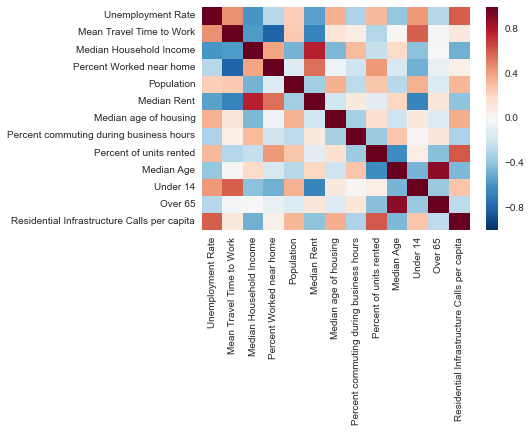

In [30]:
#heatmap of the same
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    sns.heatmap(dfAnalysis.join(dfTargets["Residential Infrastructure Calls per capita"]).corr())

### Successful regression - Residential Infrastructure Call Rate by Zip

In [31]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    #drop these fields, not useful in the regression
    lstFeaturesToExcludeResidential = ['Population', 'Median Household Income', 'Median Age', 'Mean Travel Time to Work',\
                            'Percent commuting during business hours', "Under 14", "Over 65", "Percent Worked near home"]
    dfX = dfAnalysis.drop(lstFeaturesToExcludeResidential, axis = 1)   
    
    #Normalize since the scale is much larger
    lst_X = ["Median Rent"]
    dfX[lst_X] = dfX[lst_X].apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))

    serY = dfTargets["Residential Infrastructure Calls per capita"]

    X_train, X_test, y_train, y_test = cross_validation.train_test_split(dfX, serY, test_size=0.3, random_state=3)
    regLinear = linear_model.LinearRegression()   
    regLinear.fit(X_train, y_train)
    
    score_Train = regLinear.score(X_train, y_train)
    score_Test = regLinear.score(X_test, y_test)    

    print()
    print("*******")
    print("Linear regression on Residential Infrastructure Calls per capita")
    print("Features: ", dfX.columns.values)
    print('Accuracy of model on train data: ' + str(round(100*float(score_Train),1)) + '%')
    print('Accuracy of model on test data: ' + str(round(100*float(score_Test),1)) + '%')
    print("*******")
    print()    

    model = smf.ols(formula='serY ~ dfX', data=dfX)

    lm_formula = model.fit()

    lm_OLS = smf.OLS(serY, dfX, data=dfX).fit()

    # 2. print the full summary
    print(lm_formula.summary())
    
#Random Forest Classifier with Grid Search on Estimators, Max Features, and Max Depth
           
    yBucket = dfTargets['Residential Infrastructure Calls per capita bucket']  # Our target

    parameter_grid = [
      {'n_estimators': list(range(1, 50, 10)),
      'max_features': list(range(1, 10, 10)),
      'max_depth': list(range(3, 10, 1))}
     ]

    regGS = grid_search.GridSearchCV(RandomForestClassifier(), param_grid= parameter_grid, \
                                   cv=8, scoring='accuracy')
    regGS.fit(dfX, yBucket)
    print("Random Forest Accuracy Score: %s" %("{:10.2f}%".format(100*float(regGS.best_score_))))
    print("Random Forest Best Estimator")
    print("   Max Depth: %d" %(regGS.best_estimator_.max_depth))
    print("   Max Features: %d" %(regGS.best_estimator_.max_features))
    print("   Estimators: %d" %(regGS.best_estimator_.n_estimators))
    
    #Decision Tree
    model = DecisionTreeClassifier()
    model.fit(dfX, yBucket)

    dt_accuracy_scores = cross_validation.cross_val_score(model, dfX, yBucket, scoring='accuracy', cv=5)
    dt_f1_scores = cross_validation.cross_val_score(model, dfX, yBucket, scoring='f1_weighted', cv=5)

    print("Dec. Trees Mean Accuracy Score", dt_accuracy_scores.mean())
    print("Dec. Trees Mean F1 Scores", dt_f1_scores.mean())
    print("Features: ", dfX.columns.values)
    print("Feature importances", model.feature_importances_)  


*******
Linear regression on Residential Infrastructure Calls per capita
Features:  ['Unemployment Rate' 'Median Rent' 'Median age of housing'
 'Percent of units rented']
Accuracy of model on train data: 60.7%
Accuracy of model on test data: 57.6%
*******

                            OLS Regression Results                            
Dep. Variable:                   serY   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     64.84
Date:                Tue, 09 Aug 2016   Prob (F-statistic):           2.40e-33
Time:                        15:06:45   Log-Likelihood:                -453.09
No. Observations:                 177   AIC:                             916.2
Df Residuals:                     172   BIC:                             932.1
Df Model:                           4                                         
Covariance Type:            non

### Graph of feature relationships for Residential Infrastructure Model

/Users/mattbritton/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


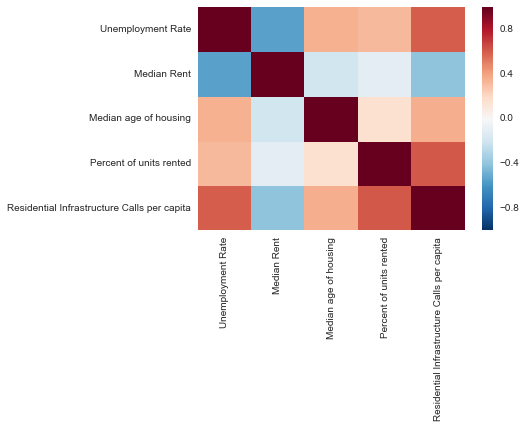

In [32]:
dfAnalysisResidential = dfX.join(dfTargets["Residential Infrastructure Calls per capita"])
sns.heatmap(dfAnalysisResidential.corr())

/Users/mattbritton/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


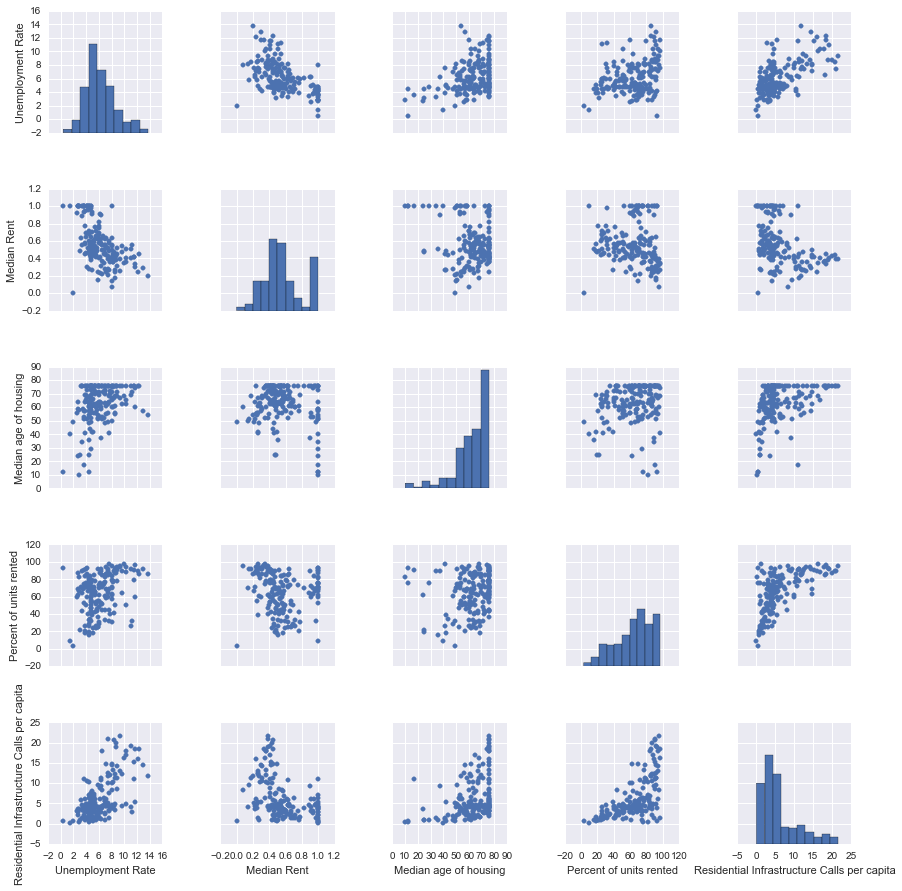

In [33]:
plt.figure(figsize=(30,30)) 
sns.pairplot(dfAnalysisResidential)

### Unsuccessful regression - Public Infrastructure Call Rate by Zip

In [34]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    #drop these fields, not useful in the regression
    lstFeaturesToExcludePublic = ['Population', 'Median Household Income', 'Median Age', 'Mean Travel Time to Work',\
                                  'Percent commuting during business hours', "Under 14", "Over 65", \
                                  "Median Rent", "Unemployment Rate"]
    dfX = dfAnalysis.drop(lstFeaturesToExcludePublic, axis = 1)   

    serY = dfTargets["Public Infrastructure Calls per capita"]

    X_train, X_test, y_train, y_test = cross_validation.train_test_split(dfX, serY, test_size=0.3, random_state=3)
    regLinear = linear_model.LinearRegression()   
    regLinear.fit(X_train, y_train)
    
    score_Train = regLinear.score(X_train, y_train)
    score_Test = regLinear.score(X_test, y_test)    

    print()
    print("*******")
    print("Linear regression on Residential Infrastructure Calls per capita")
    print("Features: ", dfX.columns.values)
    print('Accuracy of model on train data: ' + str(round(100*float(score_Train),1)) + '%')
    print('Accuracy of model on test data: ' + str(round(100*float(score_Test),1)) + '%')
    print("*******")
    print()    

    model = smf.ols(formula='serY ~ dfX', data=dfX)

    lm_formula = model.fit()

    lm_OLS = smf.OLS(serY, dfX, data=dfX).fit()

    # 2. print the full summary
    print(lm_formula.summary())
    
#Random Forest Classifier with Grid Search on Estimators, Max Features, and Max Depth
           
    yBucket = dfTargets['Residential Infrastructure Calls per capita bucket']  # Our target

    parameter_grid = [
      {'n_estimators': list(range(1, 50, 10)),
      'max_features': list(range(1, 10, 10)),
      'max_depth': list(range(3, 10, 1))}
     ]

    regGS = grid_search.GridSearchCV(RandomForestClassifier(), param_grid= parameter_grid, \
                                   cv=8, scoring='accuracy')
    regGS.fit(dfX, yBucket)
    print("Random Forest Accuracy Score: %s" %("{:10.2f}%".format(100*float(regGS.best_score_))))
    print("Random Forest Best Estimator")
    print("   Max Depth: %d" %(regGS.best_estimator_.max_depth))
    print("   Max Features: %d" %(regGS.best_estimator_.max_features))
    print("   Estimators: %d" %(regGS.best_estimator_.n_estimators))
    
    #Decision Tree
    model = DecisionTreeClassifier()
    model.fit(dfX, yBucket)

    dt_accuracy_scores = cross_validation.cross_val_score(model, dfX, yBucket, scoring='accuracy', cv=5)
    dt_f1_scores = cross_validation.cross_val_score(model, dfX, yBucket, scoring='f1_weighted', cv=5)

    print("Dec. Trees Mean Accuracy Score", dt_accuracy_scores.mean())
    print("Dec. Trees Mean F1 Scores", dt_f1_scores.mean())
    print("Features: ", dfX.columns.values)
    print("Feature importances", model.feature_importances_)     


*******
Linear regression on Residential Infrastructure Calls per capita
Features:  ['Percent Worked near home' 'Median age of housing'
 'Percent of units rented']
Accuracy of model on train data: 39.0%
Accuracy of model on test data: 7.4%
*******

                            OLS Regression Results                            
Dep. Variable:                   serY   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     21.04
Date:                Tue, 09 Aug 2016   Prob (F-statistic):           1.14e-11
Time:                        15:06:54   Log-Likelihood:                -429.99
No. Observations:                 177   AIC:                             868.0
Df Residuals:                     173   BIC:                             880.7
Df Model:                           3                                         
Covariance Type:            nonrobust  

### Graph of feature relationships for Residential Infrastructure Model

/Users/mattbritton/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


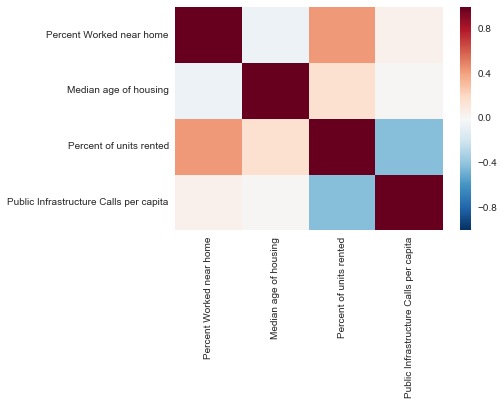

In [35]:
dfAnalysisPublic = dfX.join(dfTargets["Public Infrastructure Calls per capita"])
sns.heatmap(dfAnalysisPublic.corr())

/Users/mattbritton/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


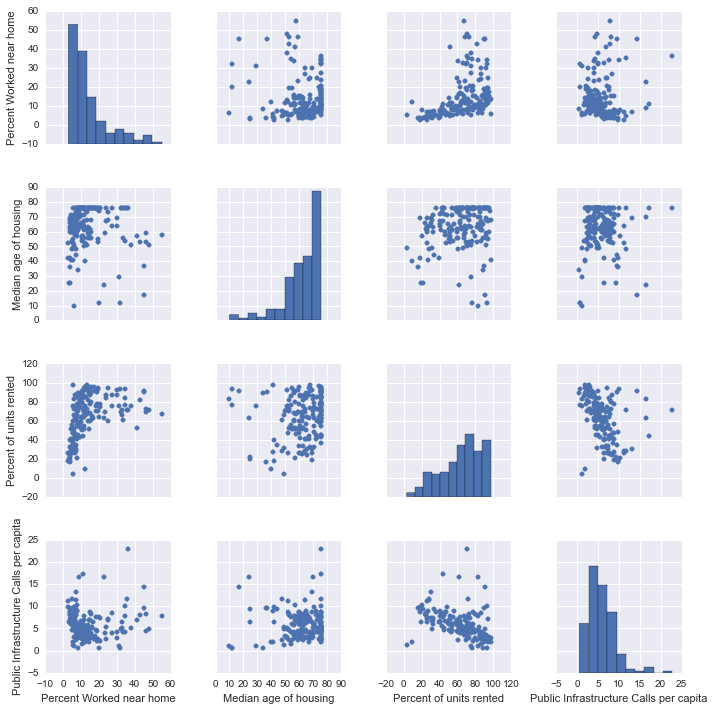

In [36]:
plt.figure(figsize=(30,30)) 
sns.pairplot(dfAnalysisPublic)

### Graph distribution of Call Rates by Zip Code
#### First graph is Sanitation/Noise/Violations, which have little relation to the variables studies in this analysis. 
#### Second graph shows the Public and Residential Infrastructure call rates, as well as the overall.

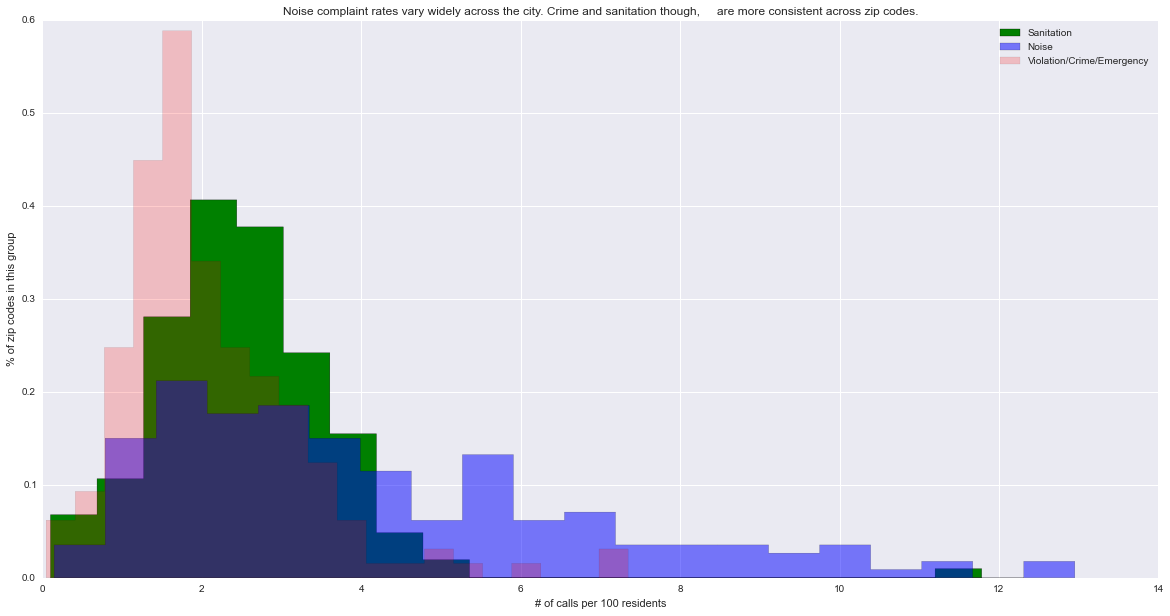

In [37]:
plt.figure(figsize=(20,10)) 
plt.hist(dfMaster["Sanitation Calls per capita"], bins=20, histtype='stepfilled', normed=True, color='g', label='Sanitation')
plt.hist(dfMaster["Noise Calls per capita"], bins=20, histtype='stepfilled', normed=True, \
         color='b', alpha=0.5, label='Noise')
#plt.hist(dfMaster["Public Infrastructure Calls per capita"], bins=20, histtype='stepfilled', normed=True, \
    #color='b', alpha=0.5, label='Public Infrastructure')
#plt.hist(dfMaster["Residential Infrastructure Calls per capita"], bins=20, histtype='stepfilled', normed=True, \
    #color='r', alpha=0.3, label='Residential Infrastructure')
plt.hist(dfMaster["Violation/Crime/Emergency Calls per capita"], bins=20, histtype='stepfilled', normed=True, \
         color='r', alpha=0.2, label='Violation/Crime/Emergency')

plt.title("Noise complaint rates vary widely across the city. Crime and sanitation though, \
    are more consistent across zip codes.")
plt.xlabel("# of calls per 100 residents")
plt.ylabel("% of zip codes in this group")
plt.legend()
plt.show()

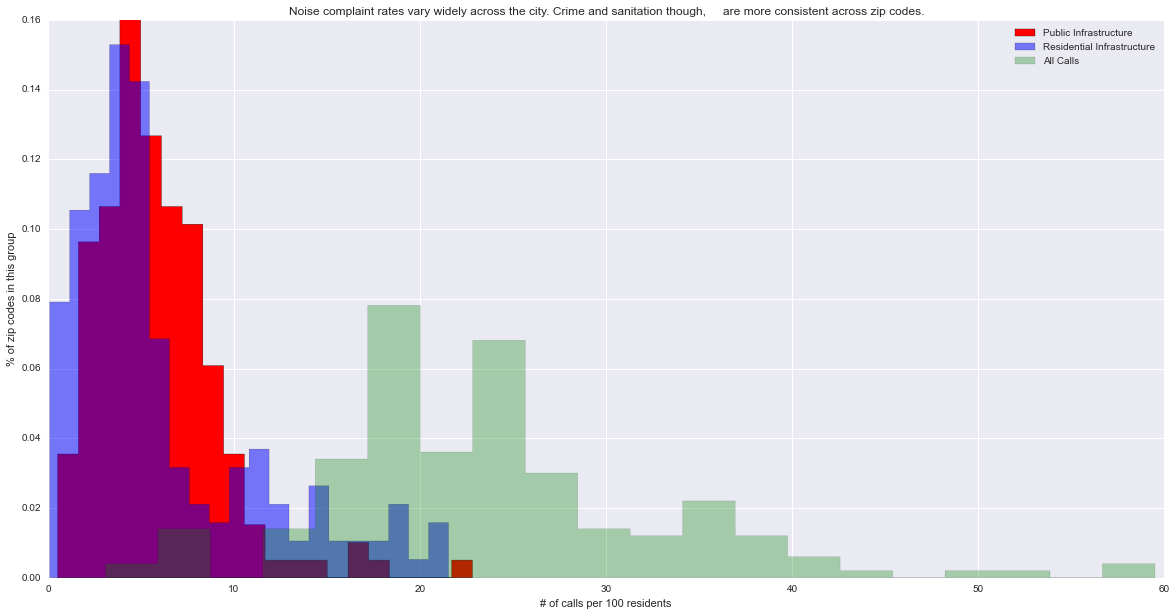

In [38]:
plt.figure(figsize=(20,10)) 

plt.hist(dfMaster["Public Infrastructure Calls per capita"], bins=20, histtype='stepfilled', normed=True, \
    color='r', alpha=1, label='Public Infrastructure')
plt.hist(dfMaster["Residential Infrastructure Calls per capita"], bins=20, histtype='stepfilled', normed=True, \
    color='b', alpha=0.5, label='Residential Infrastructure')
plt.hist(dfMaster["All Calls per capita"], bins=20, histtype='stepfilled', normed=True, \
    color='g', alpha=0.3, label='All Calls')

plt.title("Noise complaint rates vary widely across the city. Crime and sanitation though, \
    are more consistent across zip codes.")
plt.xlabel("# of calls per 100 residents")
plt.ylabel("% of zip codes in this group")
plt.legend()
plt.show()